In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import scipy.sparse.linalg

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

In [3]:
h_b_DW = 0.5*(p*p + (m*q + g*(q*q + mu*mu))**2)
h_f_DW = -0.5*(m+2*g*q)#[bdag,b]

cutoff=16

ham=Hamiltonian(h_b_DW,h_f_DW,{m:1, g:1, mu:1}, cutoff, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)

ansatz = RealAmplitudes(nq, entanglement='linear', reps=1)

In [6]:
k=7
betas=[1 for i in range(k)]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [7]:
print("------ cutoff = {} ------".format(cutoff))
#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=15,sigma=0.0)[0]
print("Lowest 7 energies = {}".format(ens))
print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

------ cutoff = 16 ------
Lowest 7 energies = [ 0.8916501 -4.69898903e-17j  0.89163849-3.28142405e-18j
  2.73421059-2.31298768e-17j  2.73432506-8.59627985e-17j
  4.84645895+1.65135277e-16j  4.84793798-6.27220490e-17j
  7.19586103+2.17336500e-16j  7.18775479-4.26125302e-16j
  9.75001443+2.72759949e-16j  9.77982411-1.02194535e-16j
 12.84455165+3.81500011e-16j 12.8329317 +3.60360003e-16j
 17.07570042+1.52156413e-16j 17.53407955+7.68569470e-16j
 22.84419743+2.60406448e-16j]
Min energy = 8.9164e-01


In [14]:

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

c:\Users\chris\anaconda3\envs\SUSYQM\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[]

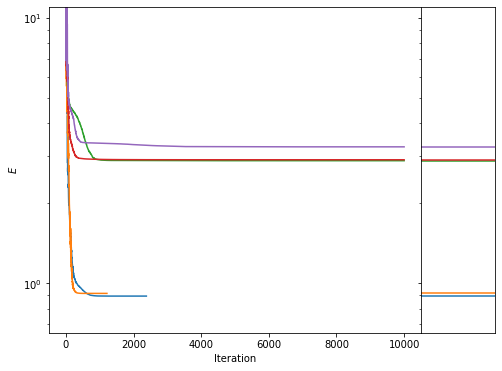

In [8]:
k=5
betas=[2,2,2,2,2]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-6), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

fig = plt.figure() 
fig.set_figheight(6)
fig.set_figwidth(8)
gs = fig.add_gridspec(1,2,wspace=0,width_ratios=[5,1])

(ax1, ax2) = gs.subplots(sharey=True)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    ax1.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
ax1.set_xlabel(r'Iteration')
ax1.set_ylabel(r'$E$')
ax1.set_ylim(0.65,11)
ax1.set_yscale('log')
#plt.legend(loc='upper right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,e in enumerate(result.eigenvalues):
    ax2.axhline(e, color=colors[i%len(colors)])
ax2.set_xticks([])

In [17]:
k=6
betas=[3 for i in range(k)]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=5000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

c:\Users\chris\anaconda3\envs\SUSYQM\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[0.8916501  2.73421059 4.84645895 7.19586103 9.75001443]
[Text(1, 0.891650104498901, '$2$'), Text(1, 2.7342105924970843, '$2$'), Text(1, 4.8464589514801055, '$2$'), Text(1, 7.195861034669861, '$2$'), Text(1, 9.750014431554414, '$2$')]


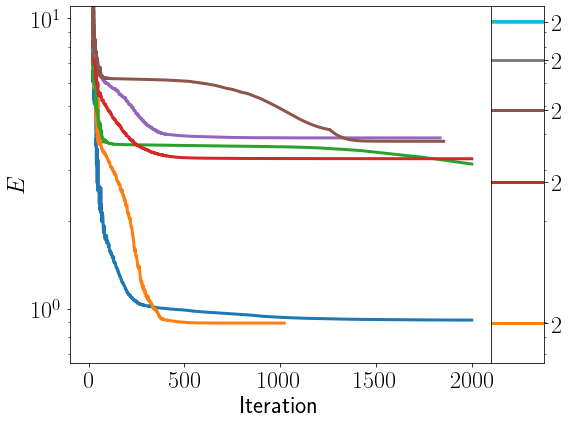

In [61]:
fig = plt.figure() 
fig.set_figheight(6)
fig.set_figwidth(8)
gs = fig.add_gridspec(1,2,wspace=0,width_ratios=[8,1])

(ax1, ax2) = gs.subplots(sharey=False)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    ax1.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$E$')
ax1.set_ylim(0.65,11)
ax1.set_yscale('log')
#plt.legend(loc='upper right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,e in enumerate(ens):
    ax2.axhline(e, color=colors[i%len(colors)])

ax2.set_xticks([])
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks([ens[i].real for i in range(0,10,2)], labels=[r"$2$" for i in range(0,10,2)])
ax2.set_ylim(0.65,11)

print(ax2.get_yticks())
print(ax2.get_yticklabels())

plt.savefig("Plots/dw_vqd.pdf")